In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
images = []
ages = []
for i in os.listdir('/content/drive/MyDrive/UTKFace/')[0:23600]:
    split = i.split('_')
    ages.append(int(split[0]))
    images.append(Image.open('/content/drive/MyDrive/UTKFace/' + i))

In [4]:
df = pd.DataFrame()
df['Images'], df['Ages'] = images, ages
df.head()

,Images,Ages
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,73
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,87
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,9
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,9
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,9


In [5]:
len(df)

23600

<ipython-input-6-e6954b02bec0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=80)


<Axes: xlabel='Ages', ylabel='Density'>

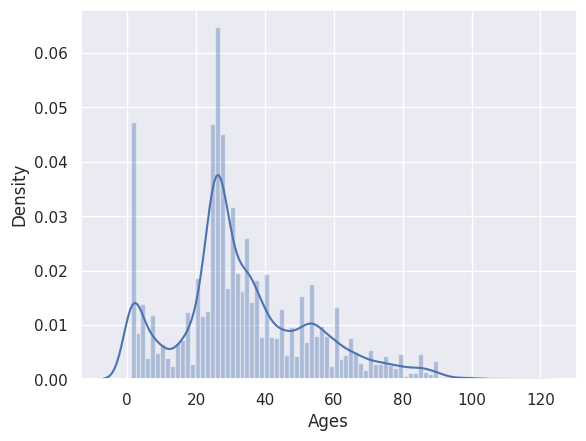

In [6]:
sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=80)

In [7]:
df =df[(df['Ages']>=20)&(df['Ages']<=35)]

In [8]:
len(df)

10514

<ipython-input-9-a7a5f7a80614>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=30)


<Axes: xlabel='Ages', ylabel='Density'>

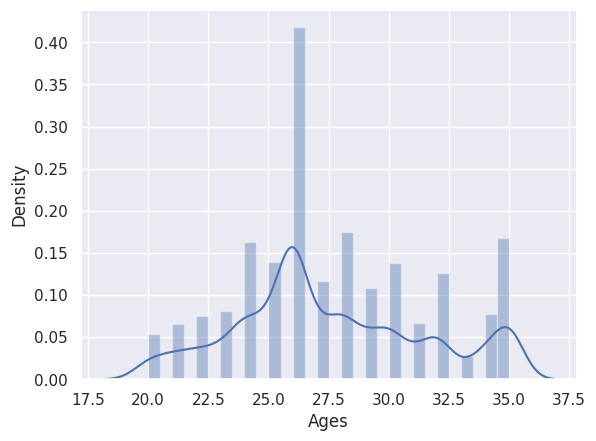

In [9]:
sns.distplot(df['Ages'],kde=True, bins=30)

In [10]:
x = []


for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((128,128), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)


x = np.array(x)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Images'].iloc[i] = df['Images'].iloc[i].resize((128,128), Image.ANTIALIAS)
<ipython-input-10-5969fe26fffd>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  df['Images'].iloc[i] = df['Images'].iloc[i].resize((128,128), Image.ANTIALIAS)
<ipython-input-10-5969fe26fffd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Images'].iloc[i] = df['Images'].iloc[i].resize((128,128), Image.ANTIALIAS)
<ipython-input-10-5969fe26fffd>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LA

In [11]:
x.shape

(10514, 128, 128, 3)

In [12]:
y_age = df['Ages'].values

# Split the data
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(
    x, y_age, test_size=0.2, stratify=y_age, random_state=42)

In [13]:
x_train_age = np.array(x_train_age)
x_test_age = np.array(x_test_age)
y_train_age = np.array(y_train_age).astype(np.float32)
y_test_age = np.array(y_test_age).astype(np.float32)

In [14]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

agemodel = Sequential()
agemodel.add(base_model)
agemodel.add(Flatten())
agemodel.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
agemodel.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mae', optimizer=Adam(lr=0.0001), metrics=['mae'])
agemodel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24350785 (92.89 MB)
Trainable params: 4326401 (16.50 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [15]:
datagen = ImageDataGenerator(
    rescale=1./255., rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
try:
    train2 = datagen.flow(x_train_age, y_train_age, batch_size=30)
    test2 = test_datagen.flow(x_test_age, y_test_age, batch_size=30)
except Exception as e:
    print(f"An error occurred: {e}")

# Proceed with model training if the data flow works correctly
if 'train2' in locals():
    agemodel.fit(train2, validation_data=test2, epochs=10)

Epoch 1/10
281/281 [==============================] - 57s 173ms/step - loss: 5.8453 - mae: 3.5794 - val_loss: 4.3615 - val_mae: 3.4873
Epoch 2/10
281/281 [==============================] - 48s 169ms/step - loss: 3.9831 - mae: 3.3275 - val_loss: 3.6411 - val_mae: 3.1425
Epoch 3/10
281/281 [==============================] - 46s 164ms/step - loss: 3.6383 - mae: 3.2180 - val_loss: 3.9131 - val_mae: 3.5575
Epoch 4/10
281/281 [==============================] - 46s 165ms/step - loss: 3.4946 - mae: 3.1804 - val_loss: 3.4769 - val_mae: 3.2010
Epoch 5/10
281/281 [==============================] - 47s 166ms/step - loss: 3.4020 - mae: 3.1519 - val_loss: 3.3996 - val_mae: 3.1691
Epoch 6/10
281/281 [==============================] - 46s 163ms/step - loss: 3.3616 - mae: 3.1504 - val_loss: 3.3094 - val_mae: 3.1158
Epoch 7/10
281/281 [==============================] - 46s 162ms/step - loss: 3.2904 - mae: 3.1087 - val_loss: 3.2706 - val_mae: 3.1044
Epoch 8/10
281/281 [==============================] - 4

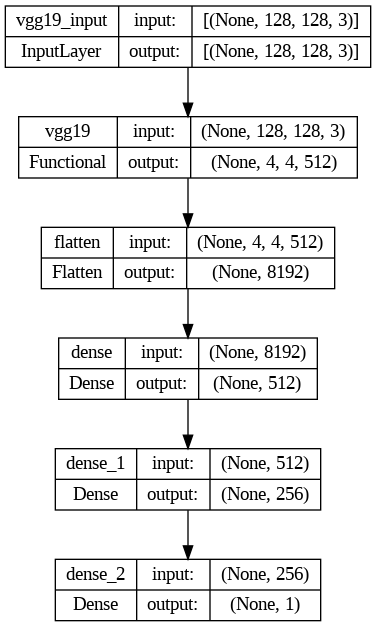

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(agemodel, to_file='model.png', show_shapes=True, show_layer_names=True)

In [18]:
agemodel.save('model_pretrain.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((128,128), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((128,128), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((128,128), Image.ANTIALIAS)

    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 128, 128, 3)

    age = agemodel.predict(ar)

    print('Age:', int(age))
    return im.resize((300,300), Image.ANTIALIAS)

1/1 [==============================] - 0s 19ms/step
Predicted Age: 28
Actual Age: 26.0


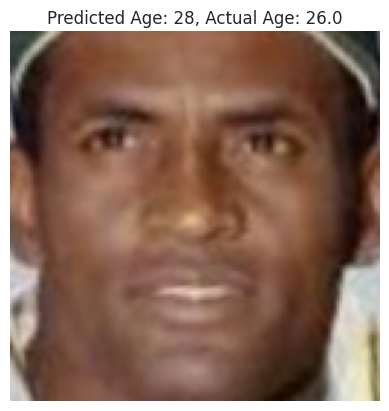

In [30]:
num = 40
age = agemodel.predict(x_test_age[num].reshape(-1, 128, 128, 3) / 255.)
age_pred = tf.round(age)

# Print the predicted and actual ages
print(f"Predicted Age: {int(age_pred[0][0])}")
print(f"Actual Age: {y_test_age[num]}")

# Display the test image
plt.imshow(x_test_age[num] / 255.)
plt.title(f"Predicted Age: {int(age_pred[0][0])}, Actual Age: {y_test_age[num]}")
plt.axis('off')
plt.show()